In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

import numpy as np
import subprocess
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

from sqlalchemy import create_engine, text
from dotenv import load_dotenv

from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import plot_reduction_errors
from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.auxmodels import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
load_dotenv()
def get_environ():
    return {"user": os.getenv("DB_USER"),
            "password": os.getenv("DB_PASSWORD"),
            "host": 'localhost',
            "port": os.getenv("DB_PORT"),
            "database": os.getenv("DB_NAME")}

def get_engine():
    EV = get_environ()
    return create_engine(f"postgresql+psycopg2://{EV['user']}:{EV['password']}@{EV['host']}:{EV['port']}/{EV['database']}")

def get_data(d_name):
    query = text(f'select * from {d_name}')
   
    res = pd.read_sql_query(query, get_engine())
    return res

In [3]:
data = (
    pd.read_csv("../data/bike.csv", parse_dates=['date'])
    .set_index('date')
    .sort_index()
)
data.head()

,count,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
date,,,,,,,,,,,,
2017-12-01 00:00:00,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-12-01 01:00:00,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-12-01 02:00:00,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-12-01 03:00:00,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-12-01 04:00:00,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
f = Forecaster(
    y = data['count'],
    current_dates=data.index,
    future_dates=24*30,
    test_length=.2,
    # metrics = ['rmse','mae','mape','r2'],
    cis=True
)
f

Forecaster(
    DateStartActuals=2017-12-01T00:00:00.000000000
    DateEndActuals=2018-11-30T23:00:00.000000000
    Freq=H
    N_actuals=8760
    ForecastLength=720
    Xvars=[]
    TestLength=1752
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

<AxesSubplot: xlabel='Date', ylabel='Values'>

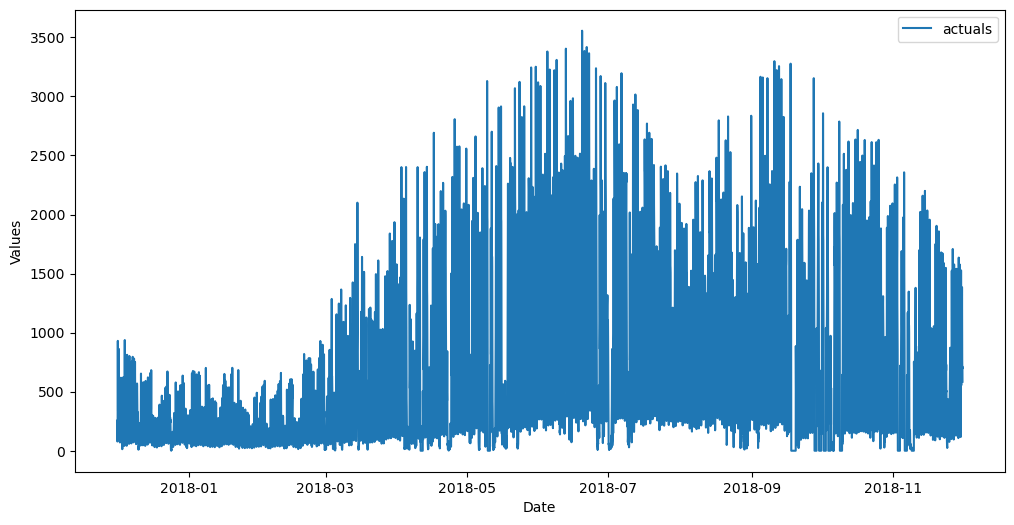

In [8]:
f.plot()

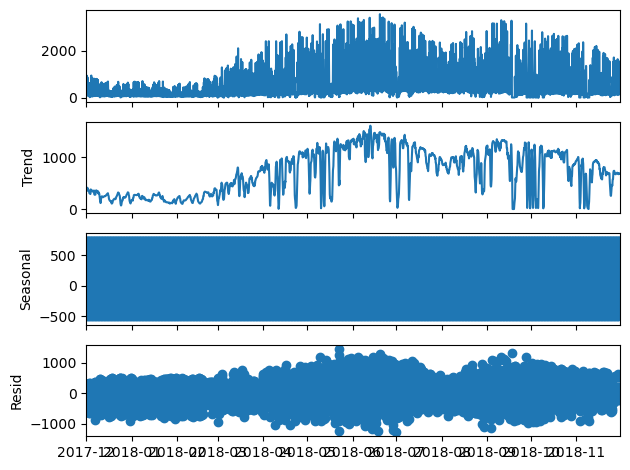

In [10]:
f.seasonal_decompose().plot();

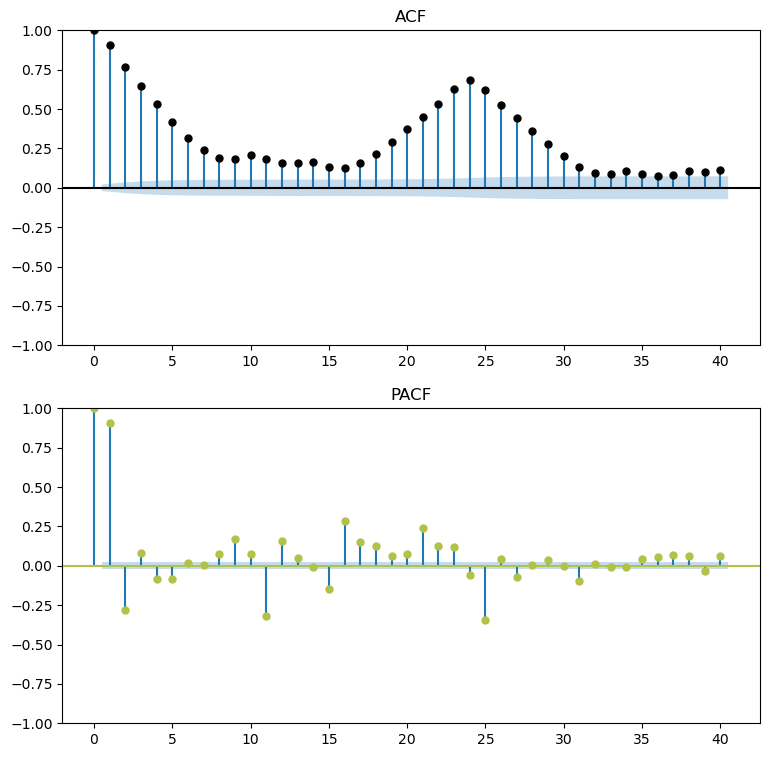

In [5]:
figs, (ax1, ax2) = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=ax1, title='ACF', lags=40, color='black')
f.plot_pacf(ax=ax2, title='PACF', lags=40, color='#B2C248', method='ywm')
plt.show();

In [7]:
f.add_seasonal_regressors('day', raw=False)
f.add_seasonal_regressors('month', raw=False)
f.add_seasonal_regressors('dayofweek', raw=False) 

In [8]:
f.auto_Xvar_select() # find best look-back, trend, and seasonality for your series

KeyboardInterrupt: 

In [ ]:
f.add_time_trend()
f.add_seasonal_regressors('year', raw=False, sincos=True)
f.auto_Xvar_select(cross_validate=True) # find best look-back, trend, and seasonality for your series

# Tell the Object to Evaluate Confidence Intervals
f.eval_cis(mode = True, cilevel = .95)

In [ ]:
linear_sklearn_models=['mlr', 'lasso','ridge','elasticnet','sgd']

for model in linear_sklearn_models:
    f.set_estimator(model)
    f.cross_validate(k=5) # tune model hyperparams using time series cross validation
    f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams

f.plot_test_set(ci=True, models=linear_sklearn_models ,order_by='TestSetRMSE');
f.plot(ci=True,models=linear_sklearn_models,order_by='TestSetRMSE')
plt.show();